# Gather data

In [1]:
import pandas as pd
import pymongo
from pymongo import MongoClient

## Import from database

In [2]:
client = MongoClient('localhost', 27017)
db = client.Belair
collection = db.data
# Extract data, sort by timestamp and reset indexes
base_df = pd.DataFrame(list(collection.find())).reset_index(drop=True)
print(len(base_df))
base_df.head()

193008


_id            device  \
0  5c17af0d4fa20f164de4b0bb  3432333852378918   
1  5c17af2d4fa20f164de4b0c7  3432333852378918   
2  5c17af3c4fa20f164de4b0cb  3432333855378A18   
3  5c17af4d4fa20f164de4b0d4  3432333852378918   
4  5c17af604fa20f164de4b0df  3432333851378918   

                                            gateways     gpsLat    gpsLon  \
0  [{'rssi': -93, 'esp': -93.461838, 'snr': 10, '...  51.194618  4.418419   
1  [{'rssi': -104, 'esp': -104.331955, 'snr': 11,...  51.194618  4.418417   
2  [{'rssi': -107, 'esp': -111.124428, 'snr': -2,...  51.215408  4.413910   
3  [{'rssi': -107, 'esp': -107.973228, 'snr': 6, ...  51.194614  4.418419   
4  [{'rssi': -114, 'esp': -119.455406, 'snr': -4,...  51.241817  4.430120   

   hdop                 rx_time  seqNumber  spfact  
0  0.66 2018-12-17 14:13:33.410      54916       7  
1  0.69 2018-12-17 14:14:04.616      54917       7  
2  0.67 2018-12-17 14:14:19.768      15653       7  
3  0.74 2018-12-17 14:14:36.499      54918       7  
4  0.66 2018-12-17 14:14:56.056      48522       7

In [3]:
df = base_df.drop(columns=['_id', 'gateways', 'hdop'])
df.head()

device     gpsLat    gpsLon                 rx_time  seqNumber  \
0  3432333852378918  51.194618  4.418419 2018-12-17 14:13:33.410      54916   
1  3432333852378918  51.194618  4.418417 2018-12-17 14:14:04.616      54917   
2  3432333855378A18  51.215408  4.413910 2018-12-17 14:14:19.768      15653   
3  3432333852378918  51.194614  4.418419 2018-12-17 14:14:36.499      54918   
4  3432333851378918  51.241817  4.430120 2018-12-17 14:14:56.056      48522   

   spfact  
0       7  
1       7  
2       7  
3       7  
4       7

## Add features to metadata

## Get device IDs

In [4]:
device_ids = base_df['device'].unique()
device_ids

array(['3432333852378918', '3432333855378A18', '3432333851378918',
       '3432333864377C18', '3432333855376418', '3432333853376B18',
       '343233386B376717', '3432333851376518', '3432333855376318',
       '3432333860376818', '343233384D378718', '343233384F378B18',
       '343233386A377C18', '3432333864378618', '3432333857376218',
       '343233385F377C18'], dtype=object)

# Check timestamps
If most of the timestamps are matching, we can assume that the other timestamps can easily be integrated

In [5]:
for thingID in device_ids:
    # Check number of occurrences of this device in the basic database
    df_1 = df[df['device']== thingID]
    occ = len(df_1)
    path = r'C:\Users\JeffG\Desktop\Case 2 - data\data/lora.' + thingID
    df_2 = pd.read_csv(path+'\\lora.'+str(thingID) +'_' + 'airquality.no2' +'_Belair'+'.csv').drop(columns=['Unnamed: 0'])
    df_2['time'] = pd.to_datetime(df_2['time'], unit='ms')
    df_3 = df_1.merge(df_2, left_on='rx_time', right_on='time', how='inner')
    matches = len(df_3)
    print(thingID + " | occurrences: " + str(occ) + 
          "\t - \tmatches: " + str(matches) + 
          "\t - \tdiff: " + str(occ - matches) + "  \t({:.2f}%)".format((occ-matches)/matches*100))

3432333852378918 | occurrences: 12280	 - 	matches: 12275	 - 	diff: 5  	(0.04%)
3432333855378A18 | occurrences: 10159	 - 	matches: 10159	 - 	diff: 0  	(0.00%)
3432333851378918 | occurrences: 33145	 - 	matches: 32250	 - 	diff: 895  	(2.78%)
3432333864377C18 | occurrences: 38978	 - 	matches: 37695	 - 	diff: 1283  	(3.40%)
3432333855376418 | occurrences: 9784	 - 	matches: 9325	 - 	diff: 459  	(4.92%)
3432333853376B18 | occurrences: 11663	 - 	matches: 10748	 - 	diff: 915  	(8.51%)
343233386B376717 | occurrences: 7062	 - 	matches: 6574	 - 	diff: 488  	(7.42%)
3432333851376518 | occurrences: 2211	 - 	matches: 1691	 - 	diff: 520  	(30.75%)
3432333855376318 | occurrences: 9198	 - 	matches: 8734	 - 	diff: 464  	(5.31%)
3432333860376818 | occurrences: 20387	 - 	matches: 19397	 - 	diff: 990  	(5.10%)
343233384D378718 | occurrences: 801	 - 	matches: 801	 - 	diff: 0  	(0.00%)
343233384F378B18 | occurrences: 2277	 - 	matches: 2277	 - 	diff: 0  	(0.00%)
343233386A377C18 | occurrences: 9318	 - 	matches

<font color='blue'>Questions:</font>
 * Why are we lacking values for PM1 and PM10?
 * Why do some timestamps occur in the metadata but not in the metrics? The difference values gives the amount of datapoints from the metadata that does not match a timestamps from the metrics data.

# Plot start data for one sensor

In [189]:
# Choose device ID
thingID = '3432333860376818'
path = r'C:\Users\JeffG\Desktop\Case 2 - data\data/lora.' + thingID
# df1 is the part of the MongoDB with the same device ID
df1 = df[df['device']== thingID]
#Filter doubles in seqNumber
m = ~df1['seqNumber'].duplicated(keep='first')
df1 = df1[m]
# df2 is all the data we have in the metrics database of this device
df2 = pd.read_csv(path+'\\lora.'+str(thingID) +'_' + 'airquality.no2' +'_Belair'+'.csv').drop(columns=['Unnamed: 0'])
df2['time'] = pd.to_datetime(df2['time'], unit='ms')
# We merge both dataframes to find the intersection of the two
inner_join = df1.merge(df2, left_on='rx_time', right_on='time', how='inner')
# Outer join is also performed
outer_join = df1.merge(df2, left_on='rx_time', right_on='time', how='outer')

In [7]:
def calculate_diff(df):
    # Sort
    temp = df.sort_values(['rx_time'],ascending=[True]).reset_index()
    
    # Calculate time differences based on the device IDs 
    diff = temp.groupby('device')['rx_time'].diff()
    
    # Add the new columns to the previous data frame
    temp = temp.assign(diff=pd.Series(diff.values))
    temp['diff'] = temp['diff'].astype('timedelta64[s]')
    
    # Drop the rows with NaT-value
    temp = temp.dropna(subset=['diff'])
    
    return temp

In [8]:
import matplotlib.pyplot as plt

C:\Users\JeffG\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


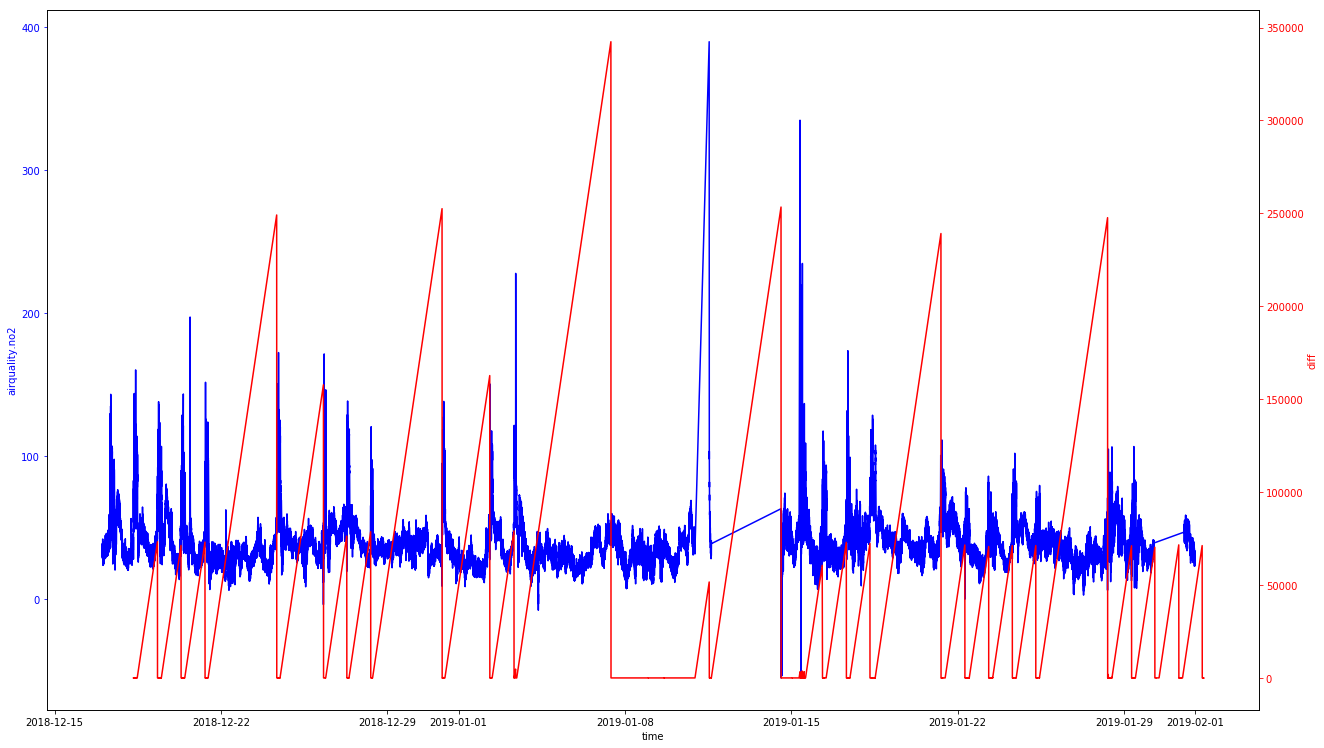

<Figure size 1080x720 with 0 Axes>

In [9]:
fig, ax1 = plt.subplots()
plt.figure(figsize=(15,10))

x1=df2['time']
y1= df2['value']
ax1.plot(x1, y1, 'b-')
ax1.set_xlabel('time')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('airquality.no2', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
df1_ = calculate_diff(df1).drop(columns=['index'])
x2=df1_['rx_time']
y2=df1_['diff']
ax2.plot(x2, y2, 'r-')
ax2.set_ylabel('diff', color='r')
ax2.tick_params('y', colors='r')

fig.set_size_inches(18.5, 10.5)

fig.tight_layout()
#fig.savefig(r'C:\Users\JeffG\Dropbox\ICT-Elektronica\Thesis\Case 1 - failing battery pack\Images\msup1g30034_voltage_light.png')
plt.show()

In [10]:
from bokeh.plotting import figure, output_file, show, output_notebook

output_notebook()

p = figure(plot_width=800, plot_height=400)

x=df1_['rx_time']
y=df1_['diff']

# add a line renderer
p.line(x, y, line_width=2)

show(p)

Loading BokehJS ...

# Check timestamp differences
I expect that the metric data covers all timestamps of the metadata and some extra (which are missing in the metadata). In order to determine this, I will do an outer join and check which datapoints occur in the metadata and not in the metrics data.

In [12]:
outer_join = outer_join.sort_values('rx_time').reset_index(drop=True)
outer_join_test = outer_join[(pd.isnull(outer_join['rx_time'])==False) & (pd.isnull(outer_join['time'])==True)]
print(len(outer_join_test))
outer_join_test.head()

990


device     gpsLat    gpsLon                 rx_time  \
13234  3432333860376818  51.194302  4.419038 2019-01-14 15:58:26.410   
19398  3432333860376818  51.234470  4.410472 2019-01-30 07:15:37.711   
19399  3432333860376818  51.233635  4.411128 2019-01-30 07:16:09.786   
19400  3432333860376818  51.233372  4.410896 2019-01-30 07:16:41.964   
19401  3432333860376818  51.233433  4.410038 2019-01-30 07:17:13.840   

       seqNumber  spfact time  value  
13234      259.0     7.0  NaT    NaN  
19398    40915.0     8.0  NaT    NaN  
19399    40916.0     8.0  NaT    NaN  
19400    40917.0     8.0  NaT    NaN  
19401    40918.0     8.0  NaT    NaN

<font color='blue'>Questions:</font>
 * Where do these differences come from? Why do we find 990 datapoints in the metadata that cannot be found in the metricsdata?

# Add features to metadata

In [118]:
from math import isnan

In [106]:
def label_before_after_missing_packet (row):
    if (row['before'] == True) & (row['after'] == False) :
        return 'before'
    elif (row['before'] == True) & (row['after'] == True) :
        return 'before and after'
    elif (row['before'] == False) & (row['after'] == True) :
        return 'after'
    else:
        return '/'

In [190]:
# Sort again
df1 = df1.sort_values('rx_time')
df1 = df1.reset_index(drop=True)
# Calculate missing packets per device ID
missing_packets = df1['seqNumber'].diff()
df1['missing_packets'] = missing_packets-1
# Check which packets were before or after a gap or both
after = df1[df1['missing_packets']>0]
before = df1.iloc[after.index-1]
before_mask = df1.index.isin(before.index)
after_mask = df1.index.isin(after.index)
df1['before'] = before_mask
df1['after'] = after_mask
df1['before_after_missing_packet']=df1.apply (lambda row: label_before_after_missing_packet(row), axis=1)
df1 = df1.drop(columns=['before', 'after'])
df1 = df1.dropna()

In [191]:
sum(df1['missing_packets'])

14493.0

In [192]:
df1.head()

device     gpsLat    gpsLon                 rx_time  seqNumber  \
1  3432333860376818  51.233864  4.411022 2018-12-18 07:39:35.801      13593   
2  3432333860376818  51.233288  4.411140 2018-12-18 07:40:06.653      13594   
3  3432333860376818  51.233299  4.411136 2018-12-18 07:40:38.956      13595   
4  3432333860376818  51.234459  4.413162 2018-12-18 07:41:41.240      13597   
5  3432333860376818  51.234039  4.413690 2018-12-18 07:42:13.113      13598   

   spfact  missing_packets before_after_missing_packet  
1       8              0.0                           /  
2       7              0.0                           /  
3       7              0.0                      before  
4       7              1.0                       after  
5       7              0.0                           /

In [62]:
df1.to_csv(r'C:\Users\JeffG\Desktop\Case 2 - data\testing\df1_test.csv')

In [102]:
df1.isna().sum()

device                         0
gpsLat                         0
gpsLon                         0
rx_time                        0
seqNumber                      0
spfact                         0
missing_packets                0
before_after_missing_packet    0
dtype: int64

# Fit missing data
Those datapoints that occur in the metrics data but not in the metadata need to be integrated in the dataframe

## For one sensor

In [226]:
# Data that is in the metadata but not in the metrics data
not_common_1 = df1[(~df1.rx_time.isin(inner_join.rx_time))]
# Data that is in the metrics data but not in the metada. We'll add this data to the metadata.
not_common_2 = df2[(~df2.time.isin(inner_join.rx_time))]

In [227]:
print("Common: " + str(len(inner_join)))
print("Not common 1: " + str(len(not_common_1)))
print("Not common 2: " + str(len(not_common_2)))

Common: 17686
Not common 1: 809
Not common 2: 83800


In [228]:
# Rename columns
not_common = not_common_2.rename(index = str, columns={"time": "rx_time"}).drop(columns=['value'])
# Add column with device ID
not_common['device'] = thingID
# Append it to the slice of the metadata of this device ID
df3 = df1.append(not_common, sort=False).sort_values('rx_time')
# Uncomment to save to .csv for testing
#df3.to_csv(r'C:\Users\JeffG\Desktop\Case 2 - data\testing\test.csv')
df3 = df3.reset_index(drop=True)
# Delete rows before first non-NaN value
idx = df3['spfact'].first_valid_index()
df3 = df3.drop(df3.index[0:idx])

In [229]:
print(df3.isna().sum())
df3.head()

device                             0
gpsLat                         80630
gpsLon                         80630
rx_time                            0
seqNumber                      80630
spfact                         80630
missing_packets                80630
before_after_missing_packet    80630
dtype: int64


device     gpsLat    gpsLon                 rx_time  \
3170  3432333860376818  51.233864  4.411022 2018-12-18 07:39:35.801   
3171  3432333860376818  51.233288  4.411140 2018-12-18 07:40:06.653   
3172  3432333860376818  51.233299  4.411136 2018-12-18 07:40:38.956   
3173  3432333860376818  51.234459  4.413162 2018-12-18 07:41:41.240   
3174  3432333860376818  51.234039  4.413690 2018-12-18 07:42:13.113   

      seqNumber  spfact  missing_packets before_after_missing_packet  
3170    13593.0     8.0              0.0                           /  
3171    13594.0     7.0              0.0                           /  
3172    13595.0     7.0              0.0                      before  
3173    13597.0     7.0              1.0                       after  
3174    13598.0     7.0              0.0                           /

### Fill up spreading factor

In [230]:
# reset index and sort on timestamp
df4 = df3.sort_values('rx_time').reset_index(drop=True)

# Fill missing SPF with interpolation that is rounded to nearest integer
df4['spfact'].interpolate(inplace=True)
df4['spfact'] = df4['spfact'].round()

In [231]:
df5 = calculate_diff(df4)
df5 = df5.drop(columns='index')
df5 = df5.reset_index(drop=True)
df5.head()

device     gpsLat    gpsLon                 rx_time  seqNumber  \
0  3432333860376818  51.233288  4.411140 2018-12-18 07:40:06.653    13594.0   
1  3432333860376818  51.233299  4.411136 2018-12-18 07:40:38.956    13595.0   
2  3432333860376818  51.234459  4.413162 2018-12-18 07:41:41.240    13597.0   
3  3432333860376818  51.234039  4.413690 2018-12-18 07:42:13.113    13598.0   
4  3432333860376818  51.234035  4.413689 2018-12-18 07:42:44.301    13599.0   

   spfact  missing_packets before_after_missing_packet  diff  
0     7.0              0.0                           /  30.0  
1     7.0              0.0                      before  32.0  
2     7.0              1.0                       after  62.0  
3     7.0              0.0                           /  31.0  
4     7.0              0.0                      before  31.0

### Fill up the seqNumbers

In [232]:
for i in range(1,len(df5)):
    if (isnan(df5.iloc[i]['seqNumber'])==True):
        df5.loc[i, 'seqNumber'] = df5.loc[i-1, 'seqNumber']+round(df5.iloc[i]['diff']/30)

In [202]:
df5.to_csv(r'C:\Users\JeffG\Desktop\Case 2 - data\testing\df5_test.csv')

### Fill up the GPS locations

In [219]:
# Use interpolation

In [234]:
df6 = df5.copy()
df6['gpsLat'].interpolate(inplace=True)
df6['gpsLon'].interpolate(inplace=True)

In [235]:
df6.isna().sum()

device                             0
gpsLat                             0
gpsLon                             0
rx_time                            0
seqNumber                          0
spfact                             0
missing_packets                80630
before_after_missing_packet    80630
diff                               0
dtype: int64

### Fill up before_after_missing_packet

In [236]:
df6['before_after_missing_packet'].fillna(value='/', inplace=True)

In [237]:
df6.isna().sum()

device                             0
gpsLat                             0
gpsLon                             0
rx_time                            0
seqNumber                          0
spfact                             0
missing_packets                80630
before_after_missing_packet        0
diff                               0
dtype: int64

### Make plots

In [203]:
import folium

In [209]:
def scatter_plot(df):
    def color_producer(bef):
        if bef == 'before':
            return 'green'
        elif bef == 'before and after':
            return 'orange'
        else:
            return 'red'
        
    mp = folium.Map(location=[51.24, 4.41], 
                    zoom_start=14)

    # Generate legend
    legend_html = '''
         <div style="position: fixed; 
                     bottom: 50px; left: 50px; width: 200px; height: 75px; 
                     border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
                     ">&nbsp; <b> Legend </b> <br>
                     &nbsp; Before gap &nbsp; <i class="fa fa-circle" style="color:green"></i><br>
                     &nbsp; After gap &nbsp; <i class="fa fa-circle" style="color:red"></i>
          </div>
         '''
    # Add legend to map
    mp.get_root().html.add_child(folium.Element(legend_html))
    
    # Extract latitude, longitude and spreading factor
    lat = list(df["gpsLat"])
    lon = list(df["gpsLon"])
    device = list(df["device"])
    time = list(df["rx_time"])
    bef = list(df["before_after_missing_packet"])

    fg = folium.FeatureGroup(name="Scatter plot Anomalies")
    
    # Add circles for every data point
    for lt, ln, dev, ti, be in zip(lat, lon, device, time, bef):
        cim = folium.CircleMarker(location=[lt, ln],
                                radius = 6,
                                popup="Device: " +str(dev) + "\n Time:" + str(ti),
                                fill=True, # Set fill to True
                                fill_color=color_producer(be),
                                color = color_producer(be),
                                fill_opacity=0.7)
        fg.add_child(cim)
    
    # Add marker for bpost depot
    folium.Marker([51.237463,4.416658], popup='bpost depot').add_to(mp)
    # Add marker for car repair
    folium.Marker([51.194873, 4.417598], popup='Buga Auto').add_to(mp)

    # Show the map
    mp.add_child(fg)
    
    return mp

In [216]:
data = df5[(df5['before_after_missing_packet']=='before') | 
          (df5['before_after_missing_packet']=='after') |
          (df5['before_after_missing_packet']=='before and after')]
print(len(data))
data.isna().sum()

1908


device                         0
gpsLat                         0
gpsLon                         0
rx_time                        0
seqNumber                      0
spfact                         0
missing_packets                0
before_after_missing_packet    0
diff                           0
dtype: int64

In [218]:
scatter_plot(data.iloc[1000:])

#### IPT vs time

In [238]:
from bokeh.plotting import figure, output_file, show, output_notebook

output_notebook()

p = figure(plot_width=800, plot_height=400)

x=df6['rx_time']
y=df6['diff']

# add a line renderer
p.line(x, y, line_width=2)

show(p)

Loading BokehJS ...

#### IPT vs SPF

In [243]:
df6.groupby('spfact')['diff'].describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95, 0.99])

count       mean          std   min    25%   50%    75%    90%  \
spfact                                                                     
7.0     66489.0  39.208952  1007.945032   0.0  31.00  31.0   31.0   32.0   
8.0     14481.0  40.339065   595.513588   0.0  31.00  31.0   31.0   63.0   
9.0     15157.0  35.558686    12.848897   0.0  31.00  31.0   31.0   63.0   
10.0     2986.0  36.181514    13.874330  11.0  31.00  31.0   31.0   63.0   
11.0       10.0  62.100000    48.112022  26.0  31.25  37.5  100.5  124.7   

           95%     99%       max  
spfact                            
7.0      63.00   94.00  253365.0  
8.0      63.00   94.00   71619.0  
9.0      63.00   94.00     158.0  
10.0     63.00   94.00     189.0  
11.0    136.85  146.57     149.0

In [244]:
# prepare some data
x = df6['spfact']
y = df6['diff']


# create a new plot with a title and axis labels
p = figure(title="Scatter plot", 
           x_axis_label='SPF', 
           y_axis_label='Interpacket-time [s]', 
           plot_width = 800, 
           plot_height = 600, 
           y_range=(-10, 300), 
           x_range=(6.5, 12.5))
p.yaxis[0].formatter.use_scientific = False

# add a circle renderer with a size, color, and alpha
p.circle(x, y, size=3, color="navy", alpha=0.5)

# show the results
show(p)

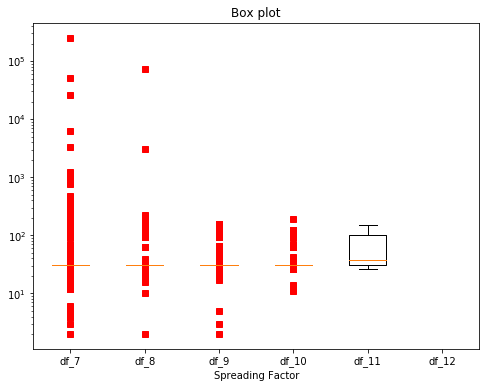

In [246]:
df_7 = df6.loc[df6['spfact'] == 7, 'diff']
df_8 = df6.loc[df6['spfact'] == 8, 'diff']
df_9 = df6.loc[df6['spfact'] == 9, 'diff']
df_10 = df6.loc[df6['spfact'] == 10, 'diff']
df_11 = df6.loc[df6['spfact'] == 11, 'diff']
df_12 = df6.loc[df6['spfact'] == 12, 'diff']

fig = plt.figure(figsize=(8,6))

axes = plt.boxplot([x for x in [df_7, df_8, df_9, df_10, df_11, df_12]], 0, 'rs', 1)
plt.xticks([y+1 for y in range(len([df_7, df_8, df_9, df_10, df_11, df_12]))], 
           ['df_7', 'df_8', 'df_9', 'df_10', 'df_11', 'df_12'])
plt.xlabel('Spreading Factor')
t = plt.title('Box plot')
plt.yscale("log")
plt.show()

## For all sensors

In [301]:
all_data = pd.DataFrame(columns=df.columns)
for dev in device_ids:
    # Choose device ID
    thingID = dev
    path = r'C:\Users\JeffG\Desktop\Case 2 - data\data/lora.' + thingID
    # df1 is the part of the MongoDB with the same device ID
    df1 = df[df['device']== thingID]
    # df2 is all the data we have in the metrics database of this device
    df2 = pd.read_csv(path+'\\lora.'+str(thingID) +'_' + 'airquality.no2' +'_Belair'+'.csv').drop(columns=['Unnamed: 0'])
    df2['time'] = pd.to_datetime(df2['time'], unit='ms')
    # We merge both dataframes to find the intersection of the two
    inner_join = df1.merge(df2, left_on='rx_time', right_on='time', how='inner')
    
    # Data that is in the metrics data but not in the metada. We'll add this data to the metadata.
    not_common_2 = df2[(~df2.time.isin(inner_join.rx_time))]
    # Rename columns
    not_common = not_common_2.rename(index = str, columns={"time": "rx_time"}).drop(columns=['value'])
    # Add column with device ID
    not_common['device'] = thingID
    # Append it to the slice of the metadata of this device ID
    df3 = df1.append(not_common, sort=False).sort_values('rx_time')
    # Uncomment to save to .csv for testing
    #df3.to_csv(r'C:\Users\JeffG\Desktop\Case 2 - data\testing\test.csv')
    df3 = df3.reset_index(drop=True)
    # Delete rows before first non-NaN value
    idx = df3['spfact'].first_valid_index()
    df3 = df3.drop(df3.index[0:idx])
    
    # reset index and sort on timestamp
    df4 = df3.sort_values('rx_time').reset_index(drop=True)

    # Fill missing SPF with interpolation that is rounded to nearest integer
    df4['spfact'].interpolate(inplace=True)
    df4['spfact'] = df4['spfact'].round()
    
    all_data = all_data.append(df4, sort=False)
    
all_data = all_data.sort_values('rx_time').reset_index(drop=True)

In [302]:
all_data.isna().sum()

device             0
gpsLat       1061165
gpsLon       1061165
rx_time            0
seqNumber    1061165
spfact             0
dtype: int64

In [303]:
all_data = calculate_diff(all_data)
all_data.drop(columns='index')

device     gpsLat    gpsLon                 rx_time  \
2        3432333852378918  51.194618  4.418417 2018-12-17 14:14:04.616   
3        3432333855378A18  51.215408  4.413910 2018-12-17 14:14:19.768   
5        3432333852378918  51.194614  4.418419 2018-12-17 14:14:36.499   
6        3432333855378A18  51.215408  4.413912 2018-12-17 14:14:51.045   
8        3432333852378918  51.194611  4.418422 2018-12-17 14:15:07.931   
9        3432333855378A18  51.215397  4.414649 2018-12-17 14:15:22.881   
10       3432333851378918  51.241817  4.430122 2018-12-17 14:15:27.380   
11       3432333852378918  51.194614  4.418433 2018-12-17 14:15:39.689   
12       3432333855378A18  51.215294  4.414744 2018-12-17 14:15:54.245   
13       3432333851378918  51.241817  4.430124 2018-12-17 14:15:59.389   
14       3432333864377C18  51.215332  4.408462 2018-12-17 14:16:01.122   
15       3432333852378918  51.194618  4.418441 2018-12-17 14:16:11.129   
16       3432333851378918  51.241852  4.430093 2018-12-17 14:16:30.604   
17       3432333864377C18  51.215347  4.408432 2018-12-17 14:16:32.466   
18       3432333852378918  51.194542  4.418395 2018-12-17 14:16:43.019   
19       3432333851378918  51.242039  4.429785 2018-12-17 14:17:02.495   
20       3432333864377C18  51.215347  4.408414 2018-12-17 14:17:04.410   
21       3432333852378918  51.194538  4.418401 2018-12-17 14:17:14.330   
22       3432333855378A18  51.217342  4.416486 2018-12-17 14:17:29.969   
23       3432333851378918  51.242035  4.429802 2018-12-17 14:17:34.036   
24       3432333864377C18  51.215347  4.408394 2018-12-17 14:17:35.768   
25       3432333852378918  51.194546  4.418411 2018-12-17 14:17:46.213   
27       3432333855378A18  51.217342  4.416484 2018-12-17 14:18:00.236   
28       3432333851378918  51.242035  4.429816 2018-12-17 14:18:05.925   
29       3432333852378918  51.194553  4.418421 2018-12-17 14:18:17.533   
30       3432333855376418  51.227119  4.519777 2018-12-17 14:18:20.527   
31       3432333855378A18  51.218533  4.416970 2018-12-17 14:18:32.069   
32       3432333851378918  51.242554  4.431252 2018-12-17 14:18:37.158   
33       3432333864377C18  51.215363  4.408419 2018-12-17 14:18:39.055   
34       3432333852378918  51.194561  4.418425 2018-12-17 14:18:49.406   
...                   ...        ...       ...                     ...   
1254143  3432333853376B18  51.207146  4.396543 2019-02-01 08:42:02.871   
1254144  3432333855376418  51.213100  4.417873 2019-02-01 08:42:06.189   
1254145  3432333860376818  51.220703  4.415653 2019-02-01 08:42:06.536   
1254146  343233386A377C18  51.227322  4.439501 2019-02-01 08:42:07.000   
1254147  3432333855376318  51.231018  4.402524 2019-02-01 08:42:13.835   
1254148  343233385F377C18  51.205490  4.446033 2019-02-01 08:42:22.325   
1254149  3432333864377C18  51.206631  4.386854 2019-02-01 08:42:25.411   
1254150  3432333864378618  51.194607  4.406876 2019-02-01 08:42:29.012   
1254151  3432333853376B18  51.207153  4.396509 2019-02-01 08:42:34.199   
1254152  343233386A377C18  51.227322  4.439500 2019-02-01 08:42:38.804   
1254153  3432333860376818  51.220692  4.415637 2019-02-01 08:42:38.944   
1254154  3432333864377C18  51.208076  4.389100 2019-02-01 08:42:57.362   
1254155  3432333864378618  51.194603  4.406851 2019-02-01 08:43:00.369   
1254156  343233385F377C18  51.205486  4.446028 2019-02-01 08:43:01.003   
1254157  3432333853376B18  51.207153  4.396507 2019-02-01 08:43:06.083   
1254158  3432333855376418  51.214382  4.416028 2019-02-01 08:43:09.250   
1254159  3432333860376818  51.220699  4.415624 2019-02-01 08:43:09.832   
1254160  343233386A377C18  51.227543  4.439464 2019-02-01 08:43:10.936   
1254161  3432333855376318  51.231358  4.403191 2019-02-01 08:43:17.224   
1254162  3432333864377C18  51.209972  4.391112 2019-02-01 08:43:28.869   
1254163  3432333864378618  51.194603  4.406844 2019-02-01 08:43:32.278   
1254164  3432333853376B18  51.207150  4.396506 2019-02-01 08:43:37.411   
1254165  34323338603768

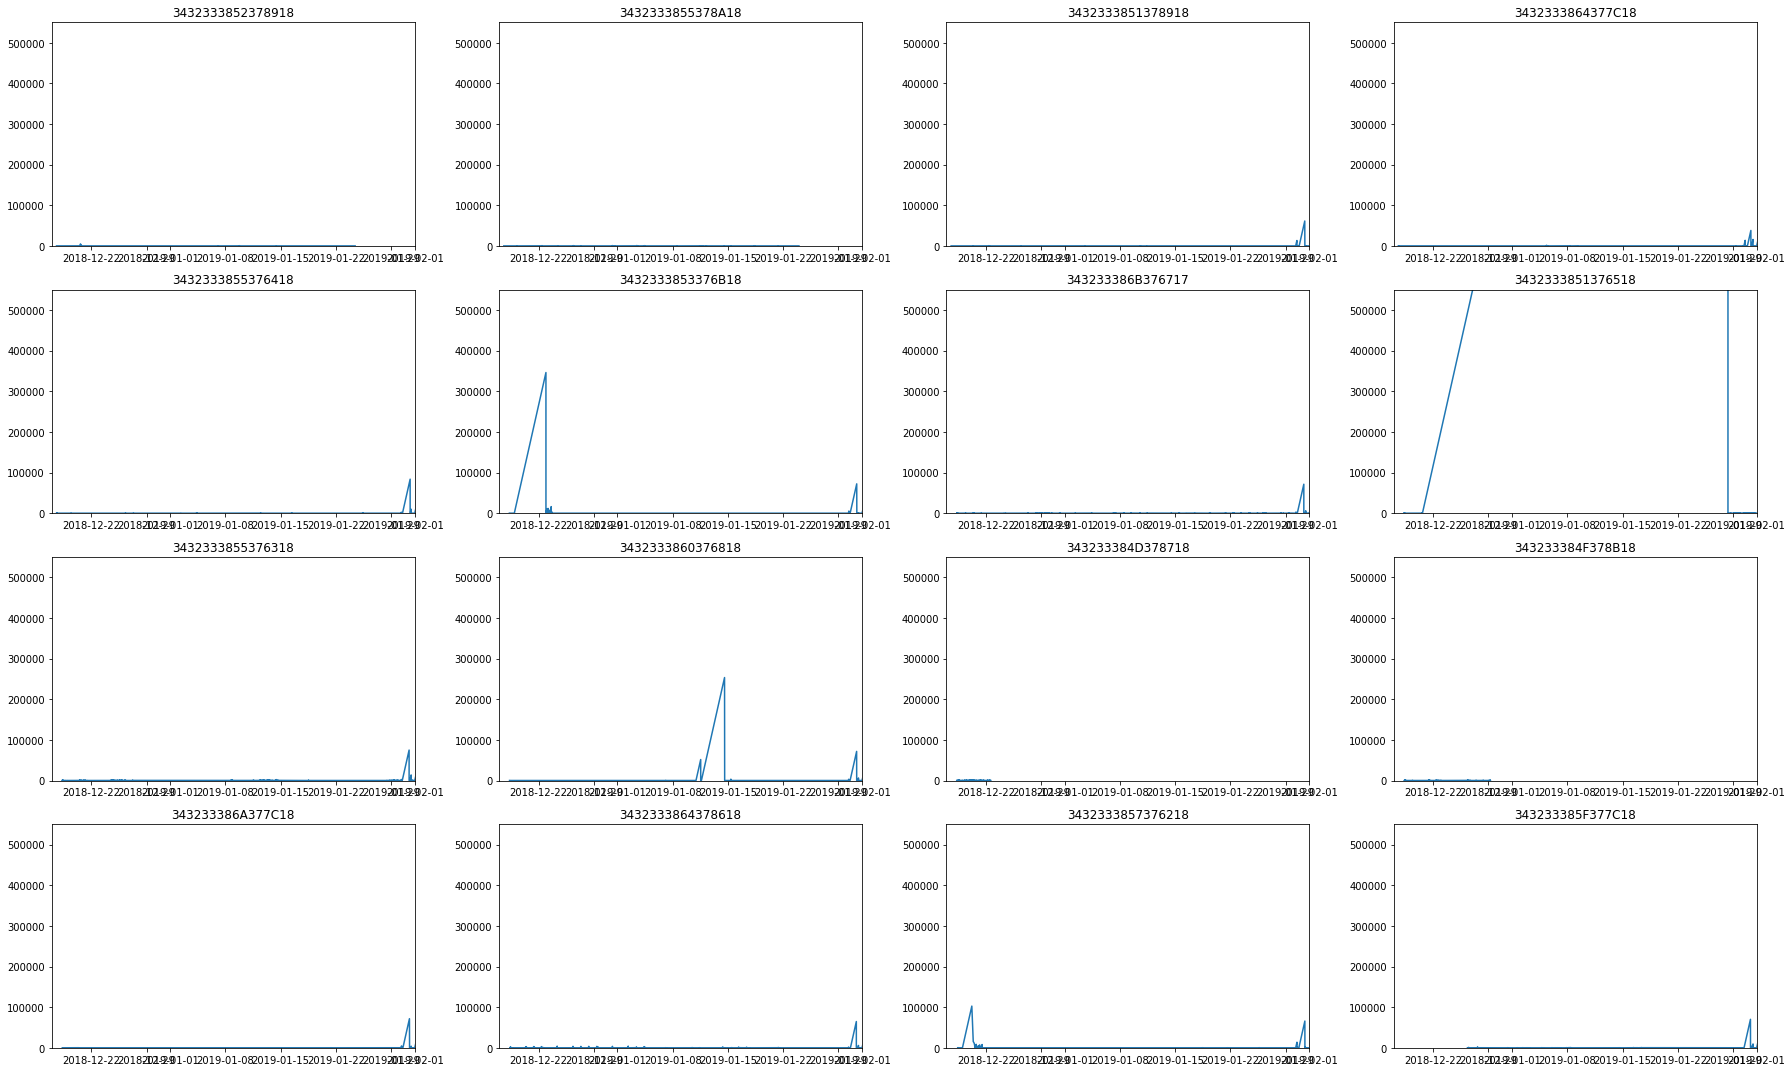

In [304]:
import datetime
categories = all_data['device'].unique()
# z = working_days[(working_days['working day'] == 1)]
fig = plt.figure(figsize=(25,15))

for c,num in zip(categories, range(1,len(categories)+1)):
    df0=all_data[all_data['device']==c]
    ax = fig.add_subplot(4, 4, num)
    ax.plot(df0['rx_time'], df0[['diff']])
    ax.set_title(c)
    ax.set_xlim([datetime.date(2018, 12, 17), datetime.date(2019, 2, 1)])
    ax.set_ylim(0,550000)
    # Plot working days
    #for xc in z.date.values:
    #    plt.axvline(x=xc, color='r', linestyle='-')

plt.tight_layout()
plt.show()

# Fill up gaps in data

In [282]:
# reset index and sort on timestamp
df4 = df3.sort_values('rx_time').reset_index(drop=True)

# Fill missing SPF with interpolation that is rounded to nearest integer
df4['spfact'].interpolate(inplace=True)
df4['spfact'] = df4['spfact'].round()
df4['spfact'].describe()

count    99309.000000
mean         7.531724
std          0.853519
min          7.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         11.000000
Name: spfact, dtype: float64

In [284]:
missing = df4[df4.isnull().any(axis=1)]

In [221]:
ipt_30 = df3_[df3_['diff']<30]
ipt_30.head()

device     gpsLat    gpsLon                 rx_time  seqNumber  \
73  3432333860376818  51.224083  4.403647 2018-12-18 08:24:55.751    13681.0   
75  3432333860376818  51.224094  4.403640 2018-12-18 08:26:01.802    13683.0   
77  3432333860376818  51.224911  4.405947 2018-12-18 08:27:07.865    13685.0   
79  3432333860376818  51.225155  4.410962 2018-12-18 08:28:13.525    13687.0   
81  3432333860376818  51.225552  4.413873 2018-12-18 08:29:19.973    13689.0   

    spfact  diff  
73    10.0  27.0  
75    10.0  27.0  
77    10.0  27.0  
79    10.0  27.0  
81     9.0  27.0

In [222]:
ipt_30_post = df3_.iloc[ipt_30.index]
ipt_30_pre = df3_.iloc[ipt_30.index-2]

In [230]:
test = ipt_30.append(ipt_30_post)
test.append(ipt_30_pre).drop_duplicates(inplace=True)

In [232]:
test.sort_values("rx_time")

device     gpsLat    gpsLon                 rx_time  \
73     3432333860376818  51.224083  4.403647 2018-12-18 08:24:55.751   
74     3432333860376818  51.224091  4.403644 2018-12-18 08:25:34.598   
75     3432333860376818  51.224094  4.403640 2018-12-18 08:26:01.802   
76     3432333860376818  51.224804  4.405279 2018-12-18 08:26:40.661   
77     3432333860376818  51.224911  4.405947 2018-12-18 08:27:07.865   
78     3432333860376818  51.225079  4.406939 2018-12-18 08:27:46.314   
79     3432333860376818  51.225155  4.410962 2018-12-18 08:28:13.525   
80     3432333860376818  51.224728  4.413626 2018-12-18 08:28:52.764   
81     3432333860376818  51.225552  4.413873 2018-12-18 08:29:19.973   
82     3432333860376818  51.225578  4.413860 2018-12-18 08:29:36.382   
82     3432333860376818  51.225578  4.413860 2018-12-18 08:29:36.382   
83     3432333860376818  51.225574  4.413846 2018-12-18 08:30:39.560   
2464   3432333860376818  51.224152  4.404302 2018-12-19 08:56:50.621   
2465   3432333860376818  51.224155  4.404292 2018-12-19 08:57:29.482   
2466   3432333860376818  51.224159  4.404295 2018-12-19 08:57:56.677   
2467   3432333860376818  51.224960  4.406028 2018-12-19 08:59:02.722   
2468   3432333860376818  51.225048  4.406945 2018-12-19 08:59:22.164   
2469   3432333860376818  51.225086  4.409845 2018-12-19 08:59:53.495   
4818   3432333860376818  51.219952  4.415143 2018-12-20 08:45:52.304   
4819   3432333860376818  51.219921  4.415354 2018-12-20 08:46:30.262   
4820   3432333860376818  51.219929  4.415348 2018-12-20 08:46:52.189   
4821   3432333860376818  51.219936  4.415354 2018-12-20 08:47:23.519   
7405   3432333860376818        NaN       NaN 2018-12-21 11:02:43.329   
7406   3432333860376818        NaN       NaN 2018-12-21 11:03:22.779   
7407   3432333860376818        NaN       NaN 2018-12-21 11:03:49.384   
7408   3432333860376818        NaN       NaN 2018-12-21 11:04:28.837   
7409   3432333860376818  51.235722  4.412851 2018-12-21 11:04:55.408   
7410   3432333860376818        NaN       NaN 2018-12-21 11:05:34.233   
8691   3432333860376818        NaN       NaN 2018-12-21 23:55:20.670   
8692   3432333860376818        NaN       NaN 2018-12-21 23:55:51.876   
...                 ...        ...       ...                     ...   
95334  3432333860376818  51.230534  4.406439 2019-01-29 11:02:19.006   
95335  3432333860376818  51.230530  4.406444 2019-01-29 11:02:57.949   
95336  3432333860376818  51.230534  4.406444 2019-01-29 11:03:25.087   
95337  3432333860376818  51.230526  4.406449 2019-01-29 11:04:04.417   
95338  3432333860376818  51.230141  4.406412 2019-01-29 11:04:31.129   
95339  3432333860376818  51.230125  4.406420 2019-01-29 11:05:09.449   
95340  3432333860376818  51.230118  4.406425 2019-01-29 11:05:20.043   
95341  3432333860376818  51.230110  4.406423 2019-01-29 11:05:51.623   
96423  3432333860376818        NaN       NaN 2019-01-29 21:57:05.147   
96424  3432333860376818        NaN       NaN 2019-01-29 21:57:37.919   
96429  3432333860376818        NaN       NaN 2019-01-29 21:59:43.691   
96430  3432333860376818        NaN       NaN 2019-01-29 22:00:46.895   
97380  3432333860376818  51.225052  4.406793 2019-01-30 08:19:27.867   
97381  3432333860376818  51.225182  4.409566 2019-01-30 08:20:05.151   
97382  3432333860376818  51.225182  4.410648 2019-01-30 08:20:33.922   
97383  3432333860376818  51.224762  4.413508 2019-01-30 08:21:11.212   
97384  3432333860376818  51.224556  4.414599 2019-01-30 08:21:39.954   
97385  3432333860376818  51.224556  4.414587 2019-01-30 08:22:17.222   
97386  3432333860376818  51.224529  4.414760 2019-01-30 08:22:34.842   
97387  3432333860376818  51.225658  4.413930 2019-01-30 08:23:05.169   
98636  3432333860376818        NaN       NaN 2019-01-31 18:44:19.224   
98637  3432333860376818        NaN       NaN 2019-01-31 18:45:25.316   
98639  3432333860376818        NaN       NaN 2019-01-31 18:46:32.008   
98640  3432333860376818        NaN       NaN 2019-01-31 1

In [240]:
zero = df3_[df3_['diff']==0]
zero_pre = df3_.iloc[zero.index-2]
test = zero.append(zero_pre).sort_values('rx_time')
test

device     gpsLat    gpsLon                 rx_time  \
13173  3432333860376818        NaN       NaN 2018-12-23 20:56:25.882   
13174  3432333860376818        NaN       NaN 2018-12-23 20:56:25.999   
35855  3432333860376818  51.222092  4.415874 2019-01-02 08:15:13.241   
35854  3432333860376818  51.222092  4.415874 2019-01-02 08:15:13.241   
40759  3432333860376818        NaN       NaN 2019-01-04 06:59:02.661   
40760  3432333860376818        NaN       NaN 2019-01-04 06:59:02.777   
40761  3432333860376818        NaN       NaN 2019-01-04 06:59:34.090   
40762  3432333860376818        NaN       NaN 2019-01-04 06:59:34.975   
50398  3432333860376818  51.194546  4.418746 2019-01-07 19:55:39.959   
50397  3432333860376818  51.194546  4.418746 2019-01-07 19:55:39.959   
53193  3432333860376818  51.194599  4.418712 2019-01-08 20:29:46.830   
53192  3432333860376818  51.194599  4.418712 2019-01-08 20:29:46.830   
58513  3432333860376818  51.194508  4.418769 2019-01-10 19:21:12.571   
58514  3432333860376818  51.194508  4.418769 2019-01-10 19:21:12.738   
58515  3432333860376818  51.194511  4.418770 2019-01-10 19:21:44.480   
58516  3432333860376818  51.194511  4.418770 2019-01-10 19:21:44.594   
96422  3432333860376818        NaN       NaN 2019-01-29 21:57:05.035   
96423  3432333860376818        NaN       NaN 2019-01-29 21:57:05.147   
96428  3432333860376818        NaN       NaN 2019-01-29 21:59:43.485   
96429  3432333860376818        NaN       NaN 2019-01-29 21:59:43.691   

       seqNumber  spfact  diff  
13173        NaN     NaN  31.0  
13174        NaN     NaN   0.0  
35855    54783.0    10.0   0.0  
35854    54783.0    10.0  37.0  
40759        NaN     NaN  31.0  
40760        NaN     NaN   0.0  
40761        NaN     NaN  31.0  
40762        NaN     NaN   0.0  
50398    69793.0     7.0   0.0  
50397    69793.0     7.0  31.0  
53193    72592.0     7.0   0.0  
53192    72592.0     7.0  32.0  
58513    77927.0     7.0  31.0  
58514    77927.0     7.0   0.0  
58515    77928.0     7.0  31.0  
58516    77928.0     7.0   0.0  
96422        NaN     NaN  31.0  
96423        NaN     NaN   0.0  
96428        NaN     NaN  31.0  
96429        NaN     NaN   0.0

In [188]:
df3_.iloc[13173]

device                 3432333860376818
gpsLat                              NaN
gpsLon                              NaN
rx_time      2018-12-23 20:56:25.999000
seqNumber                           NaN
spfact                              NaN
diff                                  0
Name: 13174, dtype: object

In [189]:
df3_.iloc[13172]

device                 3432333860376818
gpsLat                              NaN
gpsLon                              NaN
rx_time      2018-12-23 20:56:25.882000
seqNumber                           NaN
spfact                              NaN
diff                                 31
Name: 13173, dtype: object

# Find out what the reason is for the missing data
Do the gaps always occur at the same location?
Let's filter out the points before and after a gap

## Filter out the points before and after a gap

In [ ]:
all_data

In [305]:
result = pd.DataFrame(columns = list(df.columns) + ['order'])
prv = df3.iloc[0]['seqNumber']
crr = df3.iloc[1]['seqNumber']
for i in range(1,len(all_data)-1):
    nxt = df3.iloc[i+1]['seqNumber']
    if((isnan(prv)==True) & (isnan(crr)==False)):
        row = df3.iloc[i]
        row['order'] = 'before'
        result = result.append(row)
    elif ((isnan(crr)==False) & (isnan(nxt)==True)):
        row = df3.iloc[i]
        row['order'] = 'after'
        result = result.append(row)     
    prv = crr
    crr = nxt

KeyboardInterrupt: 

In [150]:
print(len(result))
result.head()

143


device     gpsLat    gpsLon                 rx_time  \
3170  3432333860376818  51.233971  4.411062 2018-12-18 07:39:03.487   
3339  3432333860376818  51.224861  4.415534 2018-12-18 09:25:57.577   
3341  3432333860376818  51.224869  4.415509 2018-12-18 09:27:00.770   
3489  3432333860376818  51.230911  4.408728 2018-12-18 10:57:36.758   
3491  3432333860376818  51.231728  4.410185 2018-12-18 10:58:40.959   

      seqNumber  spfact   order  
3170    13592.0     7.0  before  
3339    13797.0     7.0   after  
3341    13799.0     7.0  before  
3489    13971.0     7.0   after  
3491    13973.0     7.0  before

## Plot the results